# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I train an image classifier to recognize different species of flowers. We can imagine using something like this in a phone app that tells us the name of the flower our camera is looking at. In practice we'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, we can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on our dataset with transfer learning
* Use the trained classifier to predict image content

When we've completed this project, we'll have an application that can be trained on any set of labeled images. Here our network will be learning about flowers and end up as a command line application. 

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import  Image
import numpy as np
import json
import pandas as pd

# Import for keeping our session alive
from workspace_utils import active_session

## Load the data

Here we'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into three parts, training, validation, and testing. For the training, we will to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training, validation, and testing sets

# Training data transforms with data augmentation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.RandomRotation(50),
                                       transforms.RandomResizedCrop(224),
                                       transforms.ColorJitter(brightness = 2, contrast = 2),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)
                                    ])
# Validation transforms
validation_transforms = transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean,std)
                                           ])

# Testing transforms
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)
                                     ])

# Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform = train_transforms)

validation_dataset = datasets.ImageFolder(valid_dir, transform = validation_transforms)

testing_dataset = datasets.ImageFolder(test_dir, transform = test_transforms)

# Define dataloaders using the image datasets and the trainforms
trainloader = torch.utils.data.DataLoader(training_dataset, batch_size = 64, shuffle=True) 
validloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 64, shuffle=True)
testloader = torch.utils.data.DataLoader(testing_dataset, batch_size = 64, shuffle=True)

### Label mapping

We need to load in a mapping from category label to category name. This file is found in `cat_to_name.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Quick check of data in json file
df = pd.DataFrame({'flower_type': cat_to_name})
df.head(10)

,flower_type
1,pink primrose
10,globe thistle
100,blanket flower
101,trumpet creeper
102,blackberry lily
11,snapdragon
12,colt's foot
13,king protea
14,spear thistle
15,yellow iris


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we should use one of the pretrained models from `torchvision.models` to get the image features. We build and train a new feed-forward classifier using those features.

We refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Steps:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [5]:
# Detect if there is a GPU and use it if yes
# device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

class Classifier(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_layers, dropout = 0.2):
        
        super().__init__()     
        
        # self.input_size = nn.Linear(input_size, hidden_layers[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
                                  
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p=dropout)
                                  
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        for hidden_layer in self.hidden_layers:
            x = self.dropout(F.relu(hidden_layer(x)))
        x = F.log_softmax(self.output(x), dim=1)
        
        return x



In [6]:
def setup(hidden_layers, learning_rate, arch, device='gpu',  dropout = 0.2):
    
    if arch == 'vgg16':
        input_size = 25088
        # Use VGG16 model from Torchvision
        model = models.vgg16(pretrained=True)
        
    elif arch == 'densenet121':
        input_size = 1024
        # Use Densenet121 from Torchvision
        model = models.densenet121(pretrained=True)
    
    else:
        print("Sorry, this is not a valid model. Try 'vgg16' or 'densenet121'")
    
    # Freeze the parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # output_size = 102 flower categories
    output_size = 102
  
    classifier = Classifier(input_size, output_size, hidden_layers, dropout = 0.2)
    
    # Update the model's classifier    
    model.classifier = classifier
    
    # Select between gpu and cpu
    if device == 'gpu' and torch.cuda.is_available():
        device = torch.device('cuda:0') 
    else:
        device = torch.device('cpu')

    # Bring model to device
    model.to(device)
    
    # Define optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr = learning_rate)
    
    # Define loss function
    criterion = nn.NLLLoss()
    
    return model, optimizer, criterion, device



In [7]:
# Create model
model, optimizer, criterion, device = setup([500, 200], 0.001, arch='vgg16', device='gpu')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 107891087.05it/s]


In [8]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
# training the model
def train(model, trainloader, validloader, criterion, optimizer, epochs=8):
    
    epochs = epochs
    print_every = 10
    running_loss = 0
    steps = 0
    
    with active_session():
        for e in range(epochs):
            for images, labels in trainloader:
                steps += 1
                # Move input and label tensors to the device
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad() 

                log_probs = model(images)
                loss = criterion(log_probs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if steps % print_every == 0:
                    validation_loss = 0
                    accuracy = 0
                    model.eval()
                    with torch.no_grad():
                        for images, labels in validloader:
                            images, labels = images.to(device), labels.to(device)
                            log_probs = model(images)
                            batch_loss = criterion(log_probs, labels)

                            validation_loss += batch_loss.item()

                            # Calculate the accuracy
                            ps = torch.exp(log_probs)
                            top_p, top_class = ps.topk(1, dim=1)
                            equals = top_class == labels.view(*top_class.shape)
                            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    print(F'Epoch number: {e+1}/{epochs}, '        
                          F'Train loss: {running_loss/print_every:.3f}, '
                          F'Validation loss: {validation_loss/len(validloader):.3f}, '
                          F'The accuracy = {accuracy/len(validloader):.3f}')
                    running_loss = 0 
                    model.train()
                   
    return model


In [10]:
model = train(model, trainloader, validloader, criterion, optimizer) 

Epoch number: 1/8, Train loss: 4.672, Validation loss: 4.405, The accuracy = 0.075
Epoch number: 1/8, Train loss: 4.498, Validation loss: 4.164, The accuracy = 0.132
Epoch number: 1/8, Train loss: 4.384, Validation loss: 4.006, The accuracy = 0.145
Epoch number: 1/8, Train loss: 4.277, Validation loss: 3.790, The accuracy = 0.165
Epoch number: 1/8, Train loss: 4.082, Validation loss: 3.452, The accuracy = 0.276
Epoch number: 1/8, Train loss: 3.895, Validation loss: 3.216, The accuracy = 0.263
Epoch number: 1/8, Train loss: 3.914, Validation loss: 2.978, The accuracy = 0.346
Epoch number: 1/8, Train loss: 3.643, Validation loss: 2.799, The accuracy = 0.352
Epoch number: 1/8, Train loss: 3.556, Validation loss: 2.575, The accuracy = 0.374
Epoch number: 1/8, Train loss: 3.394, Validation loss: 2.397, The accuracy = 0.412
Epoch number: 2/8, Train loss: 3.394, Validation loss: 2.245, The accuracy = 0.455
Epoch number: 2/8, Train loss: 3.189, Validation loss: 2.168, The accuracy = 0.432
Epoc

## Testing our network

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. We run the test images through our function and measure the accuracy. 

In [11]:
# testing the model and returning the accuracy on new data
def testset_accuracy(model, testloader):
    
    # Bring model to GPU
    model.to(device)

    correct = 0
    total = 0
    with torch.no_grad():
        model.to(device)
        model.eval()
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
testset_accuracy(model, testloader)

Accuracy achieved by the network on test images is: 76%


## Save the checkpoint

Now that our network is trained, we save the model so we can load it later for making predictions. We'll want to save other things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We will attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

In [16]:
model.class_to_idx = training_dataset.class_to_idx

In [11]:
# Save the checkpoint 
checkpoint = {'classifier': model.classifier,
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }

torch.save(checkpoint, 'checkpoint.pth')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [9]:
# Function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
      
    checkpoint = torch.load(filepath)
    
    model = models.vgg16(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    for param in model.parameters():
        param.requires_grad = False
    
    return model

In [10]:
model = load_checkpoint('checkpoint.pth')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. We write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It will look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First we'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

We'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, we resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [12]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    im = Image.open(image)
    
    width, height = im.size
    # Resize image to make the shortest side 256 pixels
    if im.width > im.height:   
        (width, height) = (im.width, 256)
    elif im.width < im.height:
        (width, height) = (256, im.height)
    else:
        (width, height) = (256, 256)
    
    im.thumbnail((width, height), Image.ANTIALIAS)
    
    # new size of image
    width, height = im.size
    
    # Crop at center, make image 224x224
    reduce = 224
    left = (width - reduce)/2 
    top = (height - reduce)/2
    right = left + 224 
    bottom = top + 224

    im = im.crop((left, top, right, bottom))

    np_image = np.array(im)/255
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    np_image = (np_image - mean) / std
    
    image = np_image.transpose((2, 0, 1))
    
    return image    

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. Running the output through this function should return the original image (except for the cropped out portions).

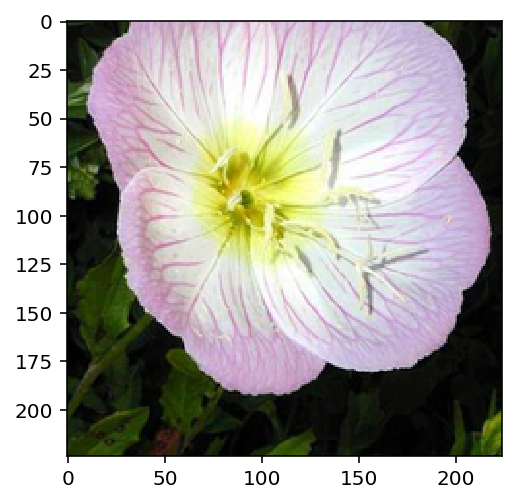

In [13]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

img='flowers/test/1/image_06743.jpg'
img = process_image(img)
imshow(img)

## Class Prediction

It's time to write a function for making predictions with our model. We will calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor we will use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We will convert these indices to the actual class labels using `class_to_idx` from our model. 

This method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [17]:
def predict(image_path, model, device = 'gpu', topk=1):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to a FloatTensor and add a 'batch_size' dimension with .unsqueeze_(0)
    image = torch.from_numpy(image).type(torch.FloatTensor).unsqueeze_(0)
    
    # Select between gpu and cpu
    if device == 'gpu' and torch.cuda.is_available():
        device = torch.device('cuda:0') 
    else:
        device = torch.device('cpu')

    # Bring model to device
    model.to(device)   
    
    with torch.no_grad():
        model.eval()
        output = model.forward(image.cuda())
        ps = torch.exp(output)
        probs, idx = ps.topk(topk, dim=1)
        
    probs, idx = probs.to('cpu'), idx.to('cpu')
    probs = probs.numpy () # converting both to numpy array
    idx = idx.numpy () 
    
    probs = probs.tolist () [0] # converting both to list
    idx = idx.tolist () [0]
    
    
    mapping = {val: key for key, val in
                model.class_to_idx.items()
                }
    
    classes = [mapping [item] for item in idx]
    
    class_names = [cat_to_name [item] for item in classes]
    class_names = np.array(class_names)
   
    classes = np.array(classes) # converting to Numpy array 
    
    return probs, classes, class_names



In [18]:
probs, classes, class_names = predict('flowers/test/1/image_06743.jpg', model, topk=5)
print(probs)
print(classes)
print(class_names)

[0.6017102003097534, 0.14905287325382233, 0.0727531760931015, 0.04388990253210068, 0.020827576518058777]
['1' '83' '77' '18' '91']
['pink primrose' 'hibiscus' 'passion flower' 'peruvian lily' 'hippeastrum']


## Sanity Checking

Now that we can use a trained model for predictions, let's check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. We'll use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. 

In [23]:
# Display an image along with the top 5 classes

def view_flower_preds(image_path, ps):
    
    image = process_image(image_path)
    imshow(image)
    probs, classes, class_names = predict(image_path, model, topk=5)
    
    class_names = [cat_to_name[item] for item in classes]
    
    data = {'probs': probs, 'classes': class_names}
    df = pd.DataFrame(data)

    plt.figure(figsize = (6,8))
    base_color = sns.color_palette()[0]
    sns.barplot(data= df, x = 'probs', y = 'classes', color = base_color)
    plt.show()
    ''' 
    sns.barplot(x=probs, y=classes, color= 'green');
    '''


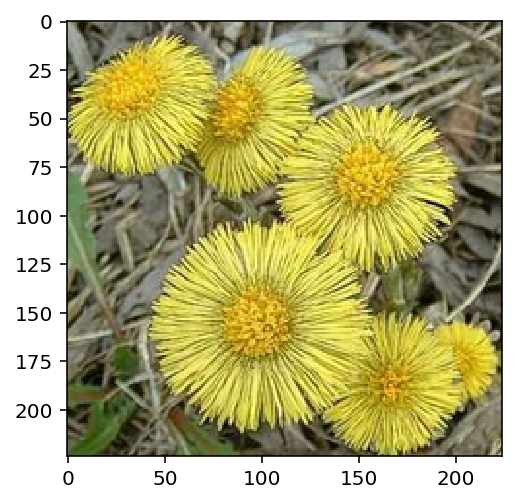

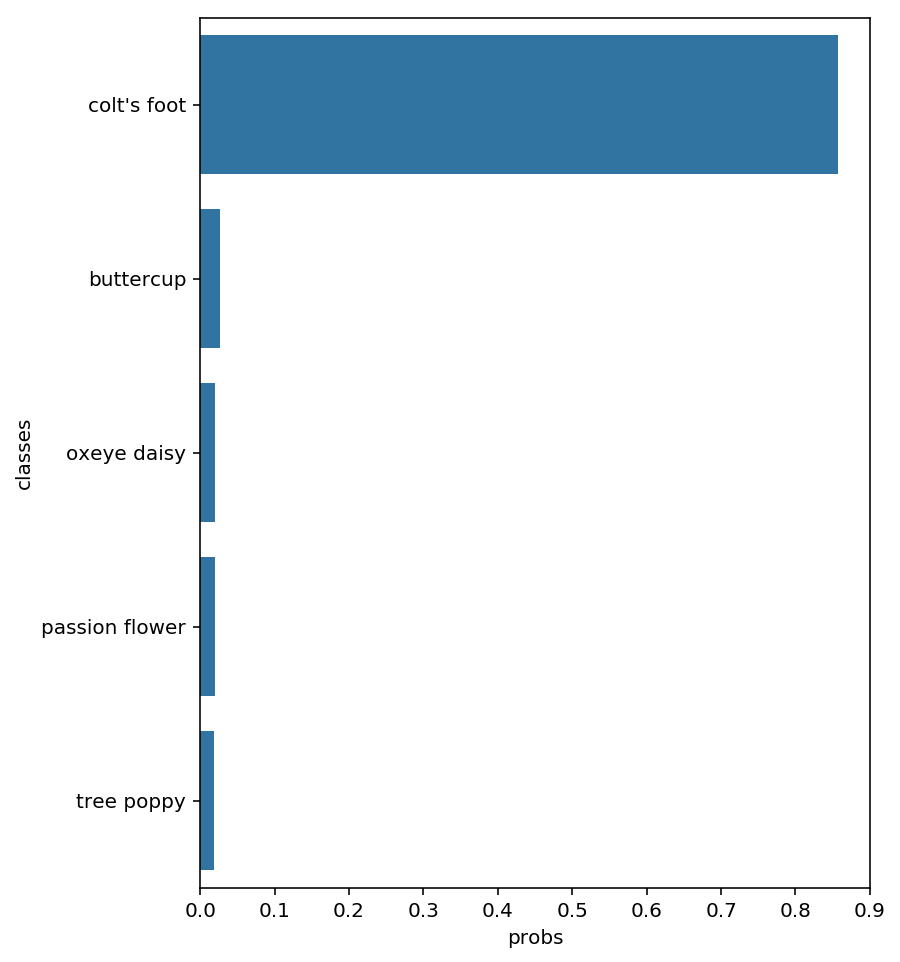

In [24]:
view_flower_preds('flowers/test/12/image_03994.jpg', classes)

Perfect! Our prediction makes sense. 

In [25]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Image Classifier Project.ipynb to html',
 '[NbConvertApp] Writing 826934 bytes to Image Classifier Project.html']